# Modelo de reconocimineto facial

-Juan David Bermúdez

## Contenido del notebook
1. Requisitos / Nota sobre entorno
2. Importación de librerías
3. Configuración y rutas
4. Preprocesamiento y generadores (explicado)
5. Exploración rápida del dataset
6. Construcción del modelo (MobileNetV2 + cabeza personalizada)
7. Callbacks y entrenamiento
8. Gráficas de entrenamiento
9. Evaluación (classification_report, confusion matrix)
10. Guardado del modelo
11. Funciones de predicción (top-k, umbral global 'Desconocido')
12. Ejemplos


### 1) Requisitos / Nota sobre el entorno
Explicación:

Este notebook está pensado para ejecutarse en un entorno local utilizando Jupyter Notebook, por lo que es fundamental contar con una instalación funcional de TensorFlow y scikit-learn, ya que son las librerías principales empleadas para la construcción, entrenamiento y evaluación del modelo. Dado que el archivo no incluye instrucciones de instalación, es responsabilidad del usuario asegurarse de que estos paquetes estén correctamente configurados en su entorno de Python. En caso de que falte alguno, basta con instalarlos mediante el comando pip install tensorflow scikit-learn. Con estas dependencias disponibles, el notebook puede ejecutarse sin inconvenientes y aprovechar al máximo las capacidades de Jupyter para visualizar resultados y desarrollar el flujo de trabajo de aprendizaje automático.


### 2) Importación de librerías
Explicación:

En esta sección se importan las librerías esenciales que permiten desarrollar el flujo completo del proyecto. Desde TensorFlow y Keras se obtienen las herramientas necesarias para construir, entrenar y utilizar el modelo basado en MobileNetV2. También se importa matplotlib, que se utiliza para visualizar imágenes, gráficos y resultados durante el proceso, junto con numpy, que facilita el manejo de arreglos numéricos. Asimismo, se emplean funciones de scikit-learn para generar métricas de evaluación como la matriz de confusión o el reporte de clasificación. Un punto importante es la función preprocess_input de MobileNetV2, la cual aplica la normalización específica que este modelo preentrenado necesita. Esta normalización prepara adecuadamente las imágenes antes de ingresarlas a la red neuronal, asegurando que se mantenga la coherencia con la forma en que MobileNetV2 fue entrenado originalmente.


In [1]:

import os
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
import itertools
import csv

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

from sklearn.metrics import classification_report, confusion_matrix


### 3) Configuración y rutas
Explicación:

En esta sección se definen las configuraciones básicas y las rutas que el programa utilizará durante todo el procesamiento. La variable DATASET_PATH corresponde a la carpeta raíz donde se encuentra el conjunto de datos, organizado en subcarpetas que representan a cada persona (por ejemplo, dataset/PersonaX/*.jpg), lo que permite que el modelo identifique automáticamente las clases según la estructura del directorio. También se establece IMG_SIZE, que define la resolución a la que se redimensionarán todas las imágenes antes de ingresarlas al modelo. Aunque MobileNetV2 puede trabajar con varios tamaños, aquí se utiliza 100x100 píxeles porque es el valor solicitado en el enunciado del trabajo. Por otro lado, UMBRAL_GLOBAL corresponde al umbral de probabilidad utilizado para determinar si una predicción es suficientemente confiable; cuando la probabilidad más alta (top1_prob) está por debajo de este valor, la imagen se clasifica como “Desconocido”. Finalmente, parámetros como BATCH_SIZE, EPOCHS y LEARNING_RATE pueden ajustarse dependiendo de la capacidad de la GPU y del tamaño del dataset, ya que influyen directamente en la velocidad y el rendimiento del entrenamiento del modelo.

In [25]:

# === CONFIG ===
DATASET_PATH = "C:\datao\DATASET_PROYECTO_OPTATIVA-20251118T193154Z-1-001\DATASET_PROYECTO_OPTATIVA" 
IMG_SIZE = (100, 100)              # Según el enunciado (100x100)
BATCH_SIZE = 32
EPOCHS = 47
LEARNING_RATE = 1e-4
UMBRAL_GLOBAL = 0.60               # Probabilidad mínima para aceptar top1 como conocido
MODEL_SAVE_PATH = "mobilenetv2_finetuned.h5"


### 4) Preprocesamiento y generadores
Explicación:

En esta parte se configura el preprocesamiento de las imágenes y se crean los generadores que proporcionarán los datos al modelo durante el entrenamiento. Para ello se utiliza ImageDataGenerator, aplicando la función preprocess_input propia de MobileNetV2, la cual se encarga de normalizar las imágenes siguiendo el mismo criterio con el que fue entrenado el modelo base. Esto garantiza una correcta compatibilidad en el flujo de datos. Además, en el generador destinado al entrenamiento se incorpora data augmentation, que incluye transformaciones como rotación, desplazamientos, zoom y volteo horizontal. Estas variaciones artificiales aumentan la diversidad del conjunto de datos y ayudan a mejorar la capacidad de generalización del modelo. Se establece también un validation_split de 0.2, lo que significa que el 20% del dataset se reserva automáticamente para la validación. Finalmente, mediante flow_from_directory, se generan dos objetos: train_generator para alimentar el modelo con los datos de entrenamiento, y val_generator para evaluar su desempeño en cada época.


In [26]:

# Generadores con augmentations para entrenamiento y solo preprocesado para validación
train_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    rotation_range=15,
    width_shift_range=0.05,
    height_shift_range=0.05,
    zoom_range=0.05,
    horizontal_flip=True,
    validation_split=0.2
)

val_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    validation_split=0.2
)

train_generator = train_datagen.flow_from_directory(
    DATASET_PATH,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='training',
    shuffle=True
)

val_generator = val_datagen.flow_from_directory(
    DATASET_PATH,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='validation',
    shuffle=False
)

num_classes = train_generator.num_classes
print("Clases detectadas:", num_classes)


Found 2231 images belonging to 28 classes.
Found 557 images belonging to 28 classes.
Clases detectadas: 28


### 5) Exploración rápida del dataset
Explicación:

En esta sección se realiza una exploración inicial del conjunto de datos con el fin de comprender mejor su estructura y calidad antes de iniciar el proceso de entrenamiento. Para ello se visualiza cuántas imágenes hay disponibles en cada clase, lo que permite identificar posibles desbalances entre categorías que podrían afectar el rendimiento del modelo. Además, se muestran algunos ejemplos de imágenes por clase, lo que facilita detectar de forma temprana cualquier problema evidente, como fotografías mal etiquetadas, archivos corruptos o imágenes con mala iluminación. Esta revisión preliminar es fundamental para asegurar que los datos utilizados sean adecuados y representativos, evitando inconvenientes durante el entrenamiento y mejorando la precisión final del modelo.


Conteo por clase (carpeta):
  Alejandro_Diaz: 100
  Alejandro_Florez: 100
  Alejandro_Jaramillo: 100
  Alejandro_Marin: 100
  Angel_David: 100
  Camilo_Jimenez: 100
  Cristhian_Motato: 100
  Daniel_Carmona: 55
  David_Puentes: 100
  Henry_Alexander: 100
  Juan_David_A: 100
  Juan_David_B: 100
  Juan_Esteban: 100
  Juan_Giron: 100
  Juan_Saavedra: 100
  Karol_Castro: 100
  Laura_Maria: 100
  Laura_Mayerly: 100
  Martin_Salazar: 95
  Miguel_Angel_B: 100
  Miyarleth_Carolay: 100
  Nicolas_Patino: 101
  Santiago_Moncada: 100
  Santiago_Taba: 160
  Santiago_Zapata: 100
  Tomas_Romero: 100
  Valentina_Zuloaga: 100
  Yarley_Mosquera: 77


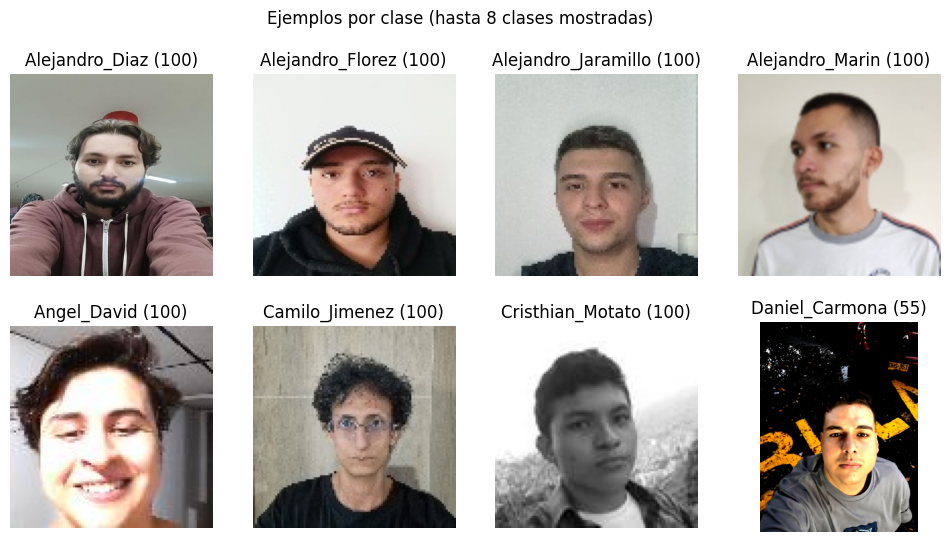

In [27]:

# Conteo por clase (aproximado, contando archivos en carpetas)
class_counts = {}
dataset_path = Path(DATASET_PATH)
for cls in dataset_path.iterdir():
    if cls.is_dir():
        files = [f for f in cls.iterdir() if f.suffix.lower() in ('.jpg','.jpeg','.png')]
        class_counts[cls.name] = len(files)

print("Conteo por clase (carpeta):")
for k, v in class_counts.items():
    print(f"  {k}: {v}")

# Mostrar hasta 8 ejemplos (una por clase)
plt.figure(figsize=(12,6))
shown = 0
for i, (cls, count) in enumerate(list(class_counts.items())[:8]):
    cls_dir = dataset_path / cls
    imgs = [f for f in cls_dir.iterdir() if f.suffix.lower() in ('.jpg','.jpeg','.png')]
    if not imgs:
        continue
    img = plt.imread(str(imgs[0]))
    plt.subplot(2,4,shown+1)
    plt.imshow(img)
    plt.title(f"{cls} ({count})")
    plt.axis("off")
    shown += 1
plt.suptitle("Ejemplos por clase (hasta 8 clases mostradas)")
plt.show()


### 6) Construcción del modelo (MobileNetV2 + cabeza personalizada)
Explicación:

En esta etapa se construye el modelo de reconocimiento facial utilizando MobileNetV2 como red base, aprovechando sus pesos preentrenados en ImageNet y cargándola sin su capa superior (include_top=False) para poder añadir nuestra propia cabeza de clasificación adaptada al dataset. Inicialmente, las capas de MobileNetV2 se mantienen congeladas con el fin de entrenar únicamente la parte superior del modelo, evitando un sobreajuste prematuro y permitiendo que las nuevas capas aprendan primero las características específicas del problema. Sobre esta base se incorpora un bloque formado por GlobalAveragePooling2D, que reduce dimensionalidad de manera eficiente, seguido de una capa densa con Dropout para disminuir el riesgo de sobreajuste y, finalmente, una capa softmax que genera tantas salidas como clases existan en el dataset (num_classes). Una vez completado este primer entrenamiento, es posible realizar un segundo paso de fine-tuning, en el que se desbloquean algunas capas de la red base para ajustar finamente sus pesos y mejorar el desempeño general del modelo.

In [28]:

# Crear modelo base MobileNetV2
base_model = MobileNetV2(include_top=False, input_shape=(IMG_SIZE[0], IMG_SIZE[1], 3), weights='imagenet')
base_model.trainable = False  # primero solo entrenamos la cabeza

inputs = Input(shape=(IMG_SIZE[0], IMG_SIZE[1], 3))
x = base_model(inputs, training=False)
x = GlobalAveragePooling2D()(x)
x = Dropout(0.3)(x)
outputs = Dense(num_classes, activation='softmax')(x)

model = Model(inputs, outputs)
model.compile(optimizer=Adam(learning_rate=LEARNING_RATE), loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()


Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 100, 100, 3)]     0         
                                                                 
 mobilenetv2_1.00_224 (Funct  (None, 4, 4, 1280)       2257984   
 ional)                                                          
                                                                 
 global_average_pooling2d_2   (None, 1280)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dropout_2 (Dropout)         (None, 1280)              0         
                                                                 
 dense_2 (Dense)             (None, 28)                35868     
                                                                 
Total params: 2,293,852
Trainable params: 35,868
Non-traina

### 7) Callbacks y entrenamiento
Explicación:

En esta sección se configuran los callbacks que optimizan y controlan el proceso de entrenamiento del modelo. El primero es EarlyStopping, cuya función es detener automáticamente el entrenamiento cuando la métrica de validación deja de mejorar durante varios ciclos, evitando así el sobreajuste y el uso innecesario de recursos. También se emplea ModelCheckpoint, que permite guardar de manera automática la mejor versión del modelo según el valor mínimo de val_loss, garantizando que siempre se conserve el estado óptimo alcanzado. Adicionalmente, se utiliza ReduceLROnPlateau, un callback que reduce la tasa de aprendizaje cuando el progreso del modelo se estanca, ayudando a refinar los ajustes en fases avanzadas del entrenamiento. En esta etapa inicial solo se entrena la “cabeza” del modelo mientras la base de MobileNetV2 permanece congelada, lo que permite que las nuevas capas aprendan sin alterar los pesos preentrenados. Si se requiere un mejor desempeño, se puede realizar un segundo entrenamiento de fine-tuning, desbloqueando las últimas capas del modelo base y utilizando una tasa de aprendizaje más baja para realizar ajustes más delicados sin desestabilizar el modelo.


In [29]:

callbacks = [
    EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True, verbose=1),
    ModelCheckpoint('mobilenetv2_best.h5', monitor='val_loss', save_best_only=True, verbose=1),
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, verbose=1)
]

history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=EPOCHS,
    callbacks=callbacks
)


Epoch 1/47
70/70 [==============================] - ETA: 0s - loss: 4.5644 - accuracy: 0.0484
Epoch 1: val_loss improved from inf to 3.61539, saving model to mobilenetv2_best.h5
70/70 [==============================] - 17s 211ms/step - loss: 4.5644 - accuracy: 0.0484 - val_loss: 3.6154 - val_accuracy: 0.0521 - lr: 1.0000e-04
Epoch 2/47
70/70 [==============================] - ETA: 0s - loss: 3.8901 - accuracy: 0.0789
Epoch 2: val_loss improved from 3.61539 to 3.23035, saving model to mobilenetv2_best.h5
70/70 [==============================] - 14s 198ms/step - loss: 3.8901 - accuracy: 0.0789 - val_loss: 3.2304 - val_accuracy: 0.1149 - lr: 1.0000e-04
Epoch 3/47
70/70 [==============================] - ETA: 0s - loss: 3.4818 - accuracy: 0.1398
Epoch 3: val_loss improved from 3.23035 to 2.93197, saving model to mobilenetv2_best.h5
70/70 [==============================] - 13s 186ms/step - loss: 3.4818 - accuracy: 0.1398 - val_loss: 2.9320 - val_accuracy: 0.1975 - lr: 1.0000e-04
Epoch 4/47


### 8) Gráficas de entrenamiento
Explicación:

En esta sección se generan las gráficas que muestran la evolución de la precisión y la pérdida tanto en el conjunto de entrenamiento como en el de validación. Estas curvas son fundamentales para evaluar el comportamiento del modelo durante el aprendizaje, ya que permiten identificar patrones como sobreajuste, subajuste o estancamiento. Al analizar estas visualizaciones, es posible determinar si el modelo está aprendiendo de manera estable o si requiere ajustes adicionales, como aplicar técnicas de regularización, modificar hiperparámetros o realizar un proceso de fine-tuning desbloqueando parte de las capas base. En conjunto, estas gráficas sirven como guía para mejorar el rendimiento del modelo y tomar decisiones informadas sobre los siguientes pasos en el proceso de entrenamiento.

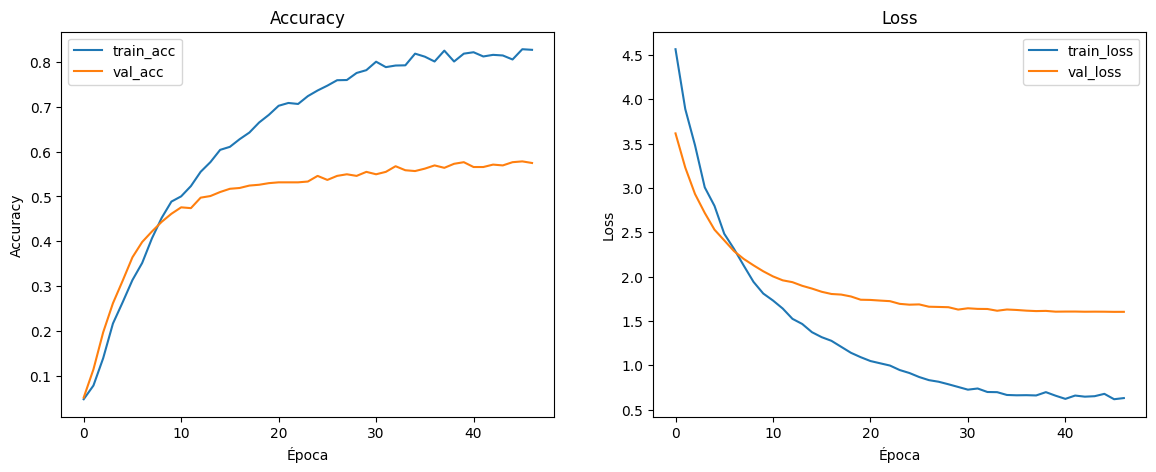

In [30]:

plt.figure(figsize=(14,5))

plt.subplot(1,2,1)
plt.plot(history.history.get('accuracy', []), label='train_acc')
plt.plot(history.history.get('val_accuracy', []), label='val_acc')
plt.title('Accuracy')
plt.xlabel('Época')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1,2,2)
plt.plot(history.history.get('loss', []), label='train_loss')
plt.plot(history.history.get('val_loss', []), label='val_loss')
plt.title('Loss')
plt.xlabel('Época')
plt.ylabel('Loss')
plt.legend()

plt.show()


### 9) Evaluación (classification_report y matriz de confusión)
Explicación:

En esta etapa se evalúa el desempeño del modelo utilizando el conjunto de validación. Para ello, primero se generan predicciones a partir del val_generator, lo que permite obtener tanto las clases predichas como las clases reales correspondientes. Con esta información se construye un classification_report, que resume métricas clave como precisión, recall y F1-score para cada clase, proporcionando una visión detallada del comportamiento del modelo en cada categoría. Además, se genera una matriz de confusión normalizada, la cual permite visualizar de manera clara qué clases están siendo correctamente identificadas y en cuáles se producen errores de clasificación. Este análisis es esencial para detectar patrones de confusión entre clases y comprender en qué áreas el modelo podría requerir ajustes adicionales o mejoras.

18/18 [==============================] - 3s 133ms/step
                     precision    recall  f1-score   support

     Alejandro_Diaz       0.71      0.85      0.77        20
   Alejandro_Florez       0.68      0.95      0.79        20
Alejandro_Jaramillo       0.07      0.05      0.06        20
    Alejandro_Marin       0.50      0.60      0.55        20
        Angel_David       0.50      0.35      0.41        20
     Camilo_Jimenez       0.47      0.80      0.59        20
   Cristhian_Motato       0.62      0.65      0.63        20
     Daniel_Carmona       0.56      0.45      0.50        11
      David_Puentes       0.32      0.35      0.33        20
    Henry_Alexander       0.80      1.00      0.89        20
       Juan_David_A       0.78      0.70      0.74        20
       Juan_David_B       0.28      0.40      0.33        20
       Juan_Esteban       0.45      0.70      0.55        20
         Juan_Giron       0.67      0.10      0.17        20
      Juan_Saavedra       1.0

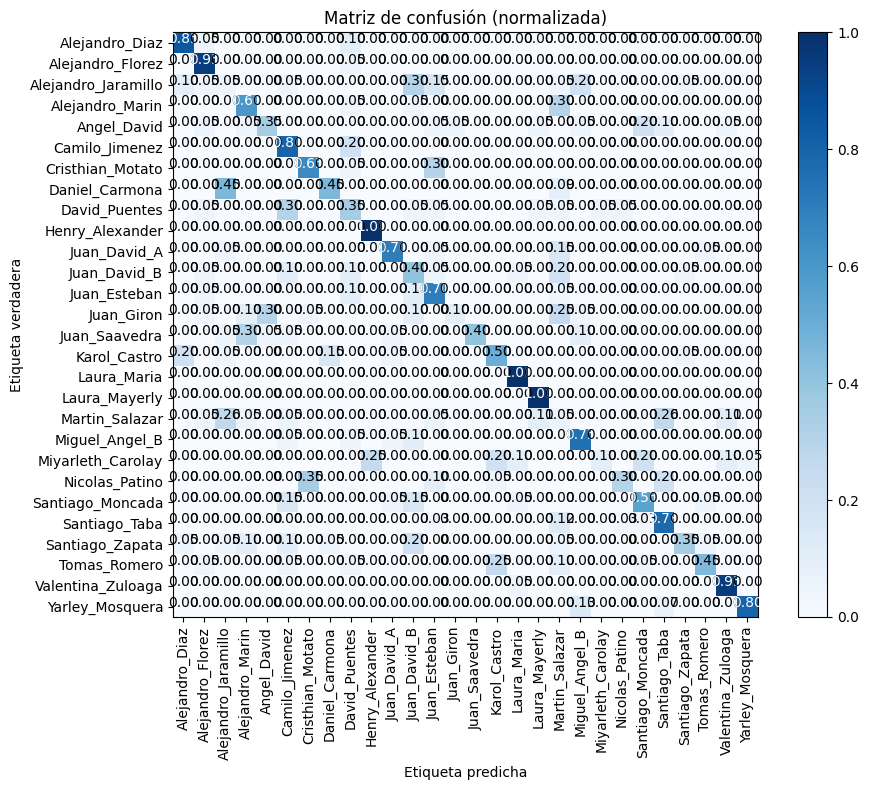

In [31]:

# Evaluación en validación
val_generator.reset()
y_pred = model.predict(val_generator, verbose=1)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = val_generator.classes
class_labels = list(train_generator.class_indices.keys())

print(classification_report(y_true, y_pred_classes, target_names=class_labels))

# Matriz de confusión normalizada
cm = confusion_matrix(y_true, y_pred_classes)
cm_norm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

def plot_confusion_matrix(cm, classes, title='Matriz de confusión (normalizada)'):
    plt.figure(figsize=(10,8))
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, f"{cm[i, j]:.2f}", horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.ylabel('Etiqueta verdadera')
    plt.xlabel('Etiqueta predicha')
    plt.tight_layout()
    plt.show()

plot_confusion_matrix(cm_norm, class_labels)


### 10) Guardar modelo
Explicación:

En esta sección se procede a guardar las versiones finales del modelo para poder reutilizarlas posteriormente sin necesidad de repetir todo el proceso de entrenamiento. Por un lado, se guarda el modelo entrenado completo en el archivo mobilenetv2_finetuned.h5, que corresponde a la versión resultante después de aplicar todos los ajustes y etapas de entrenamiento definidas en el notebook. Además, se conserva el archivo mobilenetv2_best.h5, generado mediante el callback ModelCheckpoint, el cual contiene la mejor versión del modelo según el menor valor de pérdida en la validación. Contar con ambos archivos resulta especialmente útil, ya que permite cargar el modelo directamente para realizar predicciones o realizar nuevos experimentos sin volver a entrenarlo desde cero, ahorrando tiempo y recursos computacionales.


In [32]:

# Guardar modelo final
model.save(MODEL_SAVE_PATH)
print("Modelo guardado en:", MODEL_SAVE_PATH)
if os.path.exists('mobilenetv2_best.h5'):
    print("Best model encontrado: mobilenetv2_best.h5")


Modelo guardado en: mobilenetv2_finetuned.h5
Best model encontrado: mobilenetv2_best.h5


### 11) Funciones de predicción (explicadas con detalle)
Explicación:

En esta parte del notebook se implementan las funciones encargadas de realizar predicciones individuales utilizando el modelo entrenado. Estas funciones aprovechan el valor de UMBRAL_GLOBAL, definido previamente, el cual actúa como límite mínimo de confianza para determinar si el modelo debe asignar una clase conocida o etiquetar la imagen como “Desconocido”. La función principal, predecir, se encarga de mostrar la imagen seleccionada, procesarla correctamente y generar sus probabilidades mediante la capa softmax del modelo. El proceso comienza cargando la imagen y aplicando la función preprocess_input, replicando así exactamente el mismo preprocesamiento utilizado por los generadores durante el entrenamiento. Posteriormente, se ejecuta model.predict, que devuelve un vector de probabilidades para cada clase, y mediante np.max se obtiene el valor más alto, correspondiente al top-1. Si este valor es inferior al umbral de confianza especificado, la imagen se clasifica como “Desconocido”, pero aun así se muestran las predicciones principales para referencia. En caso contrario, se devuelve la etiqueta más probable junto con el listado de las clases mejor puntuadas. De esta manera, las funciones proporcionan un mecanismo robusto para realizar predicciones confiables y detectar casos donde el modelo no se sienta lo suficientemente seguro.

In [33]:

from tensorflow.keras.preprocessing import image

# Crear mapping índice -> clase
idx2class = {v: k for k, v in train_generator.class_indices.items()}

def formato_prob(p):
    return f"{p*100:.2f}%"

def mostrar_imagen(ruta):
    try:
        img = image.load_img(ruta, target_size=IMG_SIZE)
        plt.imshow(img)
        plt.axis('off')
        plt.title(os.path.basename(ruta))
        plt.show()
    except Exception as e:
        print("No se pudo mostrar la imagen:", e)

def predecir(ruta, top_k=3, min_confidence=None, mostrar=True):
    """Predice una sola imagen usando el modelo entrenado. Usa UMBRAL_GLOBAL si no se pasa min_confidence."""
    if min_confidence is None:
        min_confidence = UMBRAL_GLOBAL

    if not os.path.exists(ruta):
        print("La ruta no existe:", ruta)
        return None, None

    try:
        img = image.load_img(ruta, target_size=IMG_SIZE)
        x = image.img_to_array(img)
        x = np.expand_dims(x, axis=0)
        x = preprocess_input(x)  # igual que los generadores

        if mostrar:
            mostrar_imagen(ruta)

        preds = model.predict(x)[0]
        top_idx = preds.argsort()[-top_k:][::-1]
        resultados = [(idx2class[i], float(preds[i])) for i in top_idx]

        top1_name, top1_prob = resultados[0]
        if top1_prob >= min_confidence:
            pred_final = top1_name
            print(f"Predicción aceptada: {pred_final} ({formato_prob(top1_prob)})")
        else:
            pred_final = "Desconocido"
            print(f"Predicción: Desconocido (top1 = {formato_prob(top1_prob)} < umbral {min_confidence*100:.0f}%)")
            print("Top-k (referencia):")

        for nombre, prob in resultados:
            marcador = "" if prob >= min_confidence else " (baja confianza)"
            print(f"  {nombre}: {formato_prob(prob)}{marcador}")

        return pred_final, resultados

    except Exception as e:
        print("Error al predecir:", e)
        return None, None

def predecir_varias(rutas, top_k=3, min_confidence=None, guardar_csv=None, mostrar=False):
    if min_confidence is None:
        min_confidence = UMBRAL_GLOBAL

    filas = []
    for ruta in rutas:
        pred_final, resultados = predecir(ruta, top_k=top_k, min_confidence=min_confidence, mostrar=mostrar)
        if resultados is None:
            continue
        fila = {"filename": os.path.basename(ruta), "pred_final": pred_final}
        for idx, (nombre, prob) in enumerate(resultados, start=1):
            fila[f"top{idx}"] = nombre
            fila[f"prob{idx}"] = prob
        filas.append(fila)

    if guardar_csv and filas:
        header = ["filename", "pred_final"]
        for i in range(1, top_k+1):
            header += [f"top{i}", f"prob{i}"]
        try:
            with open(guardar_csv, "w", newline="", encoding="utf-8") as f:
                writer = csv.DictWriter(f, fieldnames=header)
                writer.writeheader()
                for r in filas:
                    row = {k: r.get(k, "") for k in header}
                    writer.writerow(row)
            print("Resultados guardados en:", guardar_csv)
        except Exception as e:
            print("Error al guardar CSV:", e)

    return filas

def predecir_carpeta(carpeta, top_k=3, min_confidence=None, guardar_csv=None, exts=(".jpg", ".jpeg", ".png"), mostrar=False):
    if min_confidence is None:
        min_confidence = UMBRAL_GLOBAL

    if not os.path.isdir(carpeta):
        print("La carpeta no existe:", carpeta)
        return None

    rutas = [os.path.join(carpeta, f) for f in os.listdir(carpeta) if f.lower().endswith(exts)]
    rutas.sort()
    return predecir_varias(rutas, top_k=top_k, min_confidence=min_confidence, guardar_csv=guardar_csv, mostrar=mostrar)


### 12) Ejemplos
Explicación:

En esta sección se muestran ejemplos prácticos de cómo utilizar las funciones de predicción desarrolladas, incluyendo llamadas a predecir para evaluar una sola imagen, predecir_varias para procesar varias imágenes de forma consecutiva y predecir_carpeta para analizar automáticamente todos los archivos contenidos en un directorio. Estos ejemplos permiten comprender de manera clara cómo integrar el modelo entrenado en diferentes escenarios de uso.

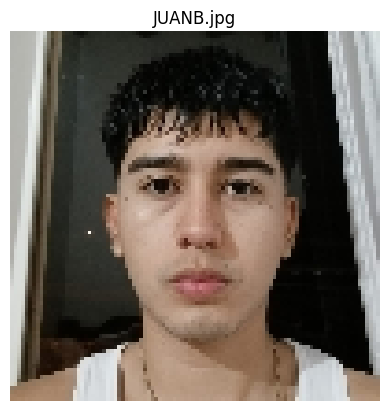

1/1 [==============================] - 0s 32ms/step
Predicción aceptada: Juan_David_B (96.44%)
  Juan_David_B: 96.44%
  Angel_David: 2.26% (baja confianza)
  Miguel_Angel_B: 0.56% (baja confianza)


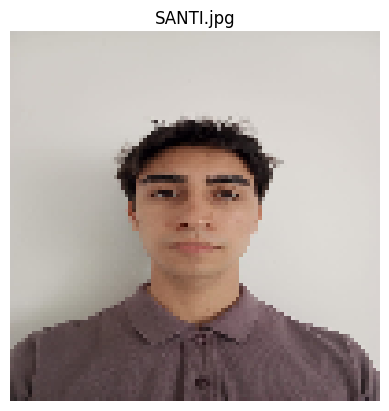

1/1 [==============================] - 0s 25ms/step
Predicción aceptada: Santiago_Moncada (97.49%)
  Santiago_Moncada: 97.49%
  Miguel_Angel_B: 0.92% (baja confianza)
  Angel_David: 0.20% (baja confianza)


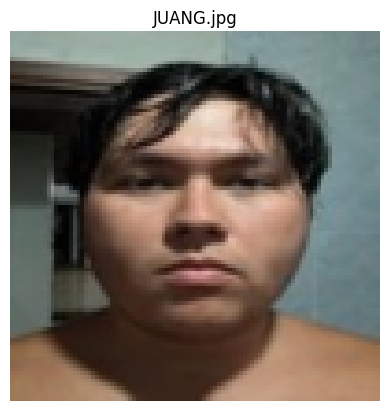

1/1 [==============================] - 0s 26ms/step
Predicción aceptada: Angel_David (67.62%)
  Angel_David: 67.62%
  Valentina_Zuloaga: 6.51% (baja confianza)
  Juan_Giron: 5.67% (baja confianza)


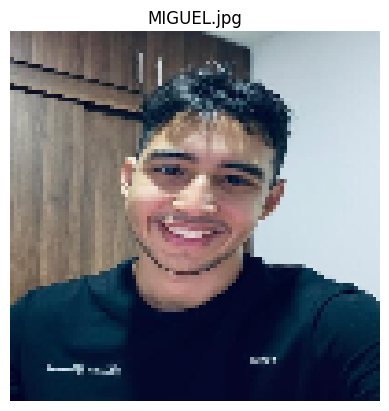

1/1 [==============================] - 0s 27ms/step
Predicción aceptada: Miguel_Angel_B (82.16%)
  Miguel_Angel_B: 82.16%
  Angel_David: 3.42% (baja confianza)
  Alejandro_Florez: 2.16% (baja confianza)


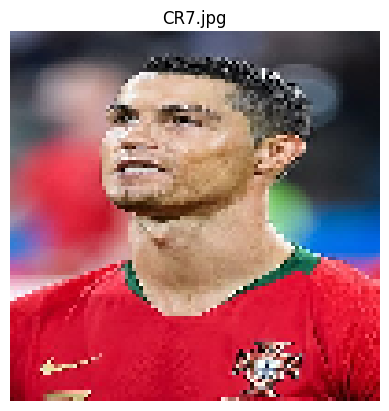

1/1 [==============================] - 0s 30ms/step
Predicción: Desconocido (top1 = 33.39% < umbral 60%)
Top-k (referencia):
  Martin_Salazar: 33.39% (baja confianza)
  Yarley_Mosquera: 21.55% (baja confianza)
  Miguel_Angel_B: 14.23% (baja confianza)


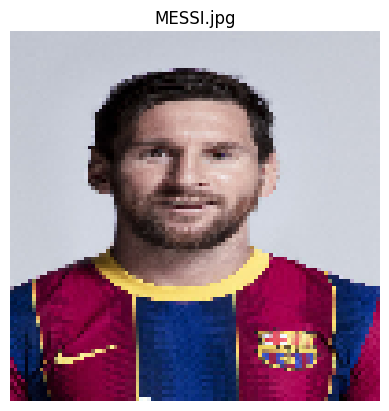

1/1 [==============================] - 0s 26ms/step
Predicción: Desconocido (top1 = 47.96% < umbral 60%)
Top-k (referencia):
  Martin_Salazar: 47.96% (baja confianza)
  Alejandro_Jaramillo: 9.94% (baja confianza)
  Henry_Alexander: 9.49% (baja confianza)


In [48]:

# Ejemplo: predecir una imagen individual (cambia la ruta)
pred_final, resultados = predecir("C:\datao\DATASET_PROYECTO_OPTATIVA-20251118T193154Z-1-001\PRUEBAS\JUANB.jpg", top_k=3, mostrar=True)

pred_final, resultados = predecir("C:\datao\DATASET_PROYECTO_OPTATIVA-20251118T193154Z-1-001\PRUEBAS\SANTI.jpg", top_k=3, mostrar=True)

pred_final, resultados = predecir("C:\datao\DATASET_PROYECTO_OPTATIVA-20251118T193154Z-1-001\PRUEBAS\JUANG.jpg", top_k=3, mostrar=True)

pred_final, resultados = predecir("C:\datao\DATASET_PROYECTO_OPTATIVA-20251118T193154Z-1-001\PRUEBAS\MIGUEL.jpg", top_k=3, mostrar=True)

pred_final, resultados = predecir("C:\datao\DATASET_PROYECTO_OPTATIVA-20251118T193154Z-1-001\PRUEBAS\CR7.jpg", top_k=3, mostrar=True)

pred_final, resultados = predecir("C:\datao\DATASET_PROYECTO_OPTATIVA-20251118T193154Z-1-001\PRUEBAS\MESSI.jpg", top_k=3, mostrar=True)

# Ejemplo: predecir varias imágenes y guardar CSV
# rutas = ['/content/test1.jpg', '/content/test2.jpg']
# filas = predecir_varias(rutas, top_k=3, guardar_csv='/content/resultados_mobilenet.csv', mostrar=False)

# Ejemplo: predecir toda una carpeta
# resultados = predecir_carpeta('/content/imagenes_test', top_k=5, guardar_csv='/content/resultados_carpeta.csv', mostrar=False)
